In [28]:
import copy

import matplotlib as mpl
import numpy as np
from fusiondls import LRBv21
from fusiondls.AnalyticCoolingCurves import LfuncKallenbachAr
from matplotlib.collections import LineCollection
from matplotlib.ticker import StrMethodFormatter

# Here are some useful labels to use for plotting throughout notebook
colors = ["teal","darkorange","firebrick","limegreen","magenta","cyan","navy"]

store_labels = dict()
store_labels["cvar"] = {"density" : "$n_{u}\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}$"}
store_labels["crel"] = {"density" : "$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ /\ q_{\parallel0} (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_names =         {"density" : "$n_{u}\ /\ n_{u0}$",
                        "power" : "$q_{\parallel0}\ /\ q_{\parallel}$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_cnames =         {"density" : "$[n_{u}\ /\ n_{u0}]^{1}$",
                        "power" : "$[q_{\parallel0}\ /\ q_{\parallel}]^{5/7}$",
                        "impurity_frac" : "$[f_{z}\ /\ f_{z0}]^{0.5}$"}
def make_colors(number, cmap):
    """make_colors(number of colours, matplotlib colormap function)"""
    colors = []
    idx = np.linspace(0,255,number)
    
    for i in range(number):
        colors.append(cmap(int(idx[i])))
                      
    return colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Overview
This notebook shows a few examples of more advanced post-processing analysis:
- Profiles of temperature and heat flux predicted by the code at various front locations
- Amount of radiation throughout the domain

# Read and visualise equilibrium
- SPR38 inner and outer, visualised.

In [29]:
eqb = file_read("eqb_store.pkl")
data = eqb["SPR38"] # Pick design to use for study

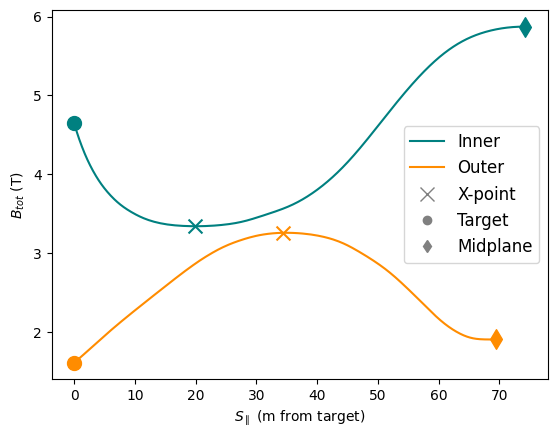

In [30]:
fig, ax = plt.subplots()

labels = {"ou":"Outer", "iu":"Inner"}
size = 100

for i, side in enumerate(["iu", "ou"]):
    d = data[side]
    Xpoint = d["Xpoint"]
    ax.plot(d["S"], d["Btot"], color = colors[i], label = labels[side])
    ax.scatter(d["S"][Xpoint], d["Btot"][Xpoint], color = colors[i], marker = "x", s = size)
    ax.scatter(d["S"][0], d["Btot"][0], color = colors[i], marker = "o", s = size)
    ax.scatter(d["S"][-1], d["Btot"][-1], color = colors[i], marker = "d", s = size)

ax.set_xlabel("$S_{\parallel}$ (m from target)")
ax.set_ylabel("$B_{tot}$ (T)")
ax.legend()

h,l = ax.get_legend_handles_labels()
extra_handles = [
    mpl.lines.Line2D([0], [0], color = "grey", marker = "x", linewidth=0, label = "X-point", markersize = 10),
    mpl.lines.Line2D([0], [0], color = "grey", marker = "o", linewidth=0, label = "Target"),
    mpl.lines.Line2D([0], [0], color = "grey", marker = "d", linewidth=0, label = "Midplane")]

ax.legend(fontsize = 12, handles = h+extra_handles)

In [31]:

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, # Upstream density (if constant)
    "nu0" : 1e20, # Upstream density (if constant)
    "cz0" : 0.02, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbachAr, # impurity cooling function. More are available in AnalyticCoolingCurves.py
}


In [32]:
cvar = "density"
design = "V10"
side = "ou"

store = dict()

for side in ["ou", "iu"]:
    d = eqb[design][side].copy() # Load in single profile into dictionary "d"
    constants = constants_default.copy() # Set settings to default
    radios = radios_default.copy() # Set settings to default
    SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 5) # Solve at these parallel positions

    if side == "iu":
        constants["qpllu0"] = constants_default["qpllu0"] * 0.1 # Reduce power to 10% for the inner divertor to account for power sharing.

    results = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar)
    
    store[side] = copy.deepcopy(results)


Solving...0.00...4.57...9.15...13.72...18.29...Complete in 0.6 seconds
Solving...0.00...3.14...6.27...9.41...12.54...Complete in 0.6 seconds


# Post-processing

## Temperature and heat flux profiles

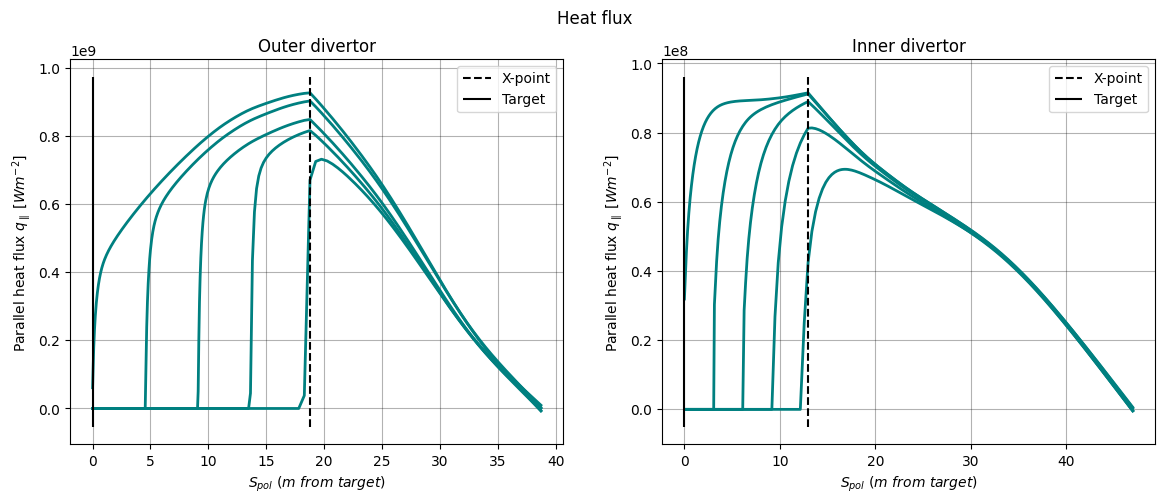

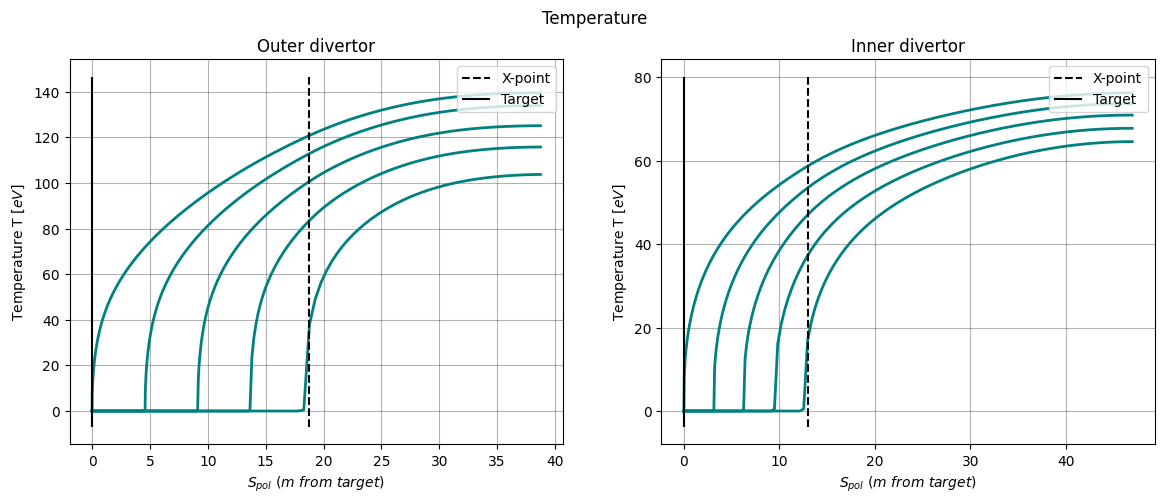

In [33]:
ylabels = {"Qprofiles": "Parallel heat flux $q_{\parallel}$ $[Wm^{-2}]$", "Tprofiles": "Temperature T $[eV]$"}
figtitles = {"Qprofiles": "Heat flux", "Tprofiles": "Temperature"}
for param in ["Qprofiles", "Tprofiles"]:

    fig, axes = plt.subplots(1,2, figsize = (14,5))
    fig.suptitle(figtitles[param])
    ax = axes[0]

    basis = "crel"

    for k, side in enumerate(["ou", "iu"]):
        for point, _ in enumerate(SparRange):
            d = eqb[design][side] # Topology and geometry data
            o = store[side].copy() # Result data
            axes[k].plot(o["Sprofiles"][point], o[param][point], linewidth = 2,  color = colors[0])

        ylim = axes[k].get_ylim()
        axes[k].vlines(d["S"][d["Xpoint"]], ylim[0], ylim[1], label = "X-point", color = "black", linestyle = "dashed")
        axes[k].vlines(0, ylim[0], ylim[1], label = "Target", color = "black", linestyle = "solid")
        axes[k].set_ylabel(ylabels[param])

    for ax in axes:
        ax.grid(color ="black", alpha = 0.3)
        ax.set_xlabel("$S_{pol}\ (m\ from\ target)$")
        ax.legend(fontsize = 10, loc = "upper right")
        ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))

    axes[0].set_title("Outer divertor")
    axes[1].set_title("Inner divertor")

## Temperature and radiation profiles
- Each line is a temperature profile for a given detachment front location.
- Each line is coloured by the radiated power in that particular location.
- Note how for positions near the target, the radiation quickly drops to 1% (two orders of magnitude below peak)
- And note how for positions near the X-point, there is still a good amount of radiation above the X-point.
- There is a sharp gradient near the detachment front where the colours drop off. This is due to very sharp temperature gradients there and the fact the cell exactly at the front location has a temperature determined by the target temperature setting (0.5eV by default) and therefore has no radiation. This is just a visual effect and goes away with higher mesh resolutions. It does not affect the answer - the code integrates across this properly.

/var/folders/rq/1dyk93h5027fx7s4mn1lpdqm0000gn/T/ipykernel_64882/1838395254.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels(["{:.2E}".format(i) for i in cb.get_ticks()])


Text(0.5, 1.0, 'Temperature profiles for scan of front locations')

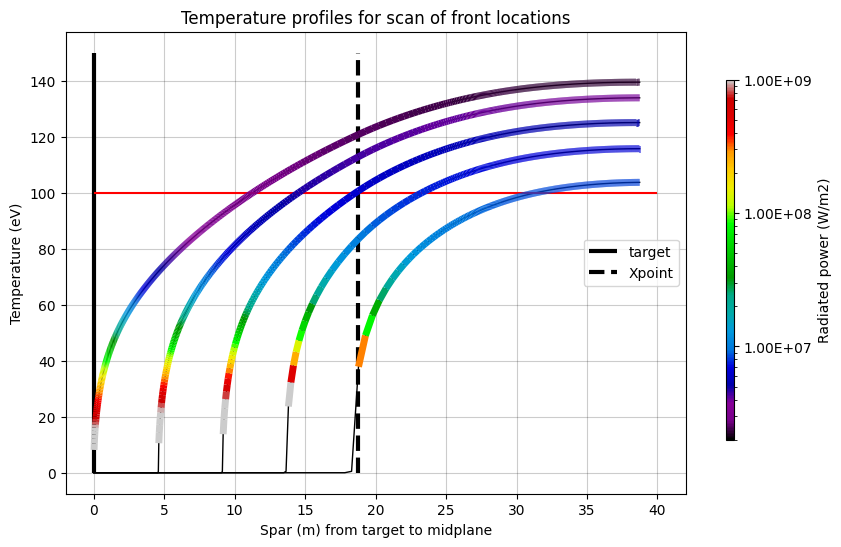

In [45]:
side = "ou"

fig, ax = plt.subplots(figsize=(8,6))
o = store[side]
d = eqb[design][side]

cmap = plt.get_cmap("plasma")
colors = make_colors(len(o["Tprofiles"]), cmap)   

for i, Tprofile in enumerate(o["Tprofiles"]):
    ax.plot(o["Sprofiles"][i], Tprofile, color = "black", linewidth = 1)
    
    x = o["Sprofiles"][i]
    y = Tprofile
    z = np.array(o["Rprofiles"][i])
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    norm = mpl.colors.LogNorm(2e6, 1e9)
    lc = LineCollection(segments, cmap='nipy_spectral', norm=norm)
    lc.set_array(z)
    lc.set_linewidth(5)
    lc.set_zorder(10)
    line = ax.add_collection(lc)
    
ax.vlines(0, 0, 150, zorder = 5, label = "target", color = "black", linewidth = 3)
ax.vlines(d["S"][d["Xpoint"]], 0, 150, zorder = 5, label = "Xpoint", color = "black", linewidth = 3, linestyle = "dashed")
ax.hlines(100,0,40,color ="red", zorder = 5)

caxs =  fig.add_axes([0.95, 0.2, 0.01, 0.6])
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap("nipy_spectral")),cax=caxs,  orientation="vertical", label = "Radiated power (W/m2)")
cb.ax.set_yticklabels(["{:.2E}".format(i) for i in cb.get_ticks()]) 

ax.legend(loc="center right")
ax.grid(color = "black", alpha = 0.2)
ax.set_xlabel("Spar (m) from target to midplane")
ax.set_ylabel("Temperature (eV)")
ax.set_title("Temperature profiles for scan of front locations")

## Temperature and radiation profiles (radiation relative to peak)

/var/folders/rq/1dyk93h5027fx7s4mn1lpdqm0000gn/T/ipykernel_64882/781331579.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels(["{:.2%}".format(i) for i in cb.get_ticks()])


Text(0, 0.5, 'Temperature (eV)')

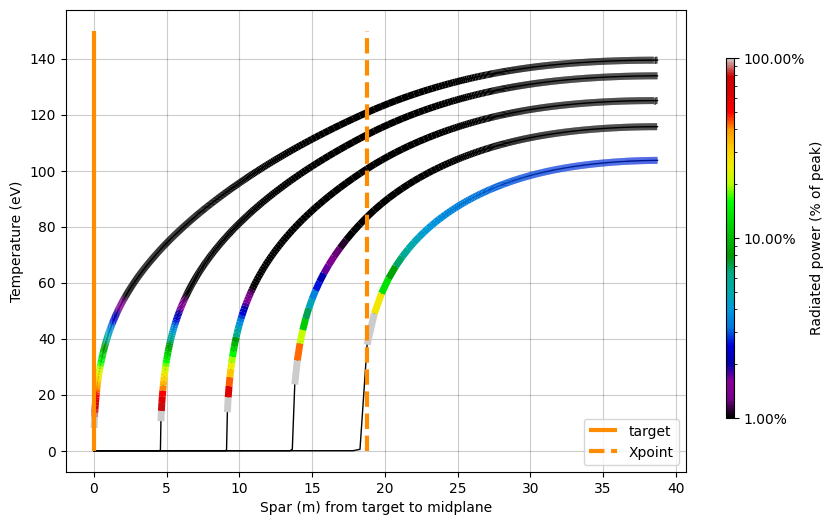

In [48]:
side = "ou"

fig, ax = plt.subplots(figsize=(8,6))

o = store[side]
d = eqb[design][side]

cmap = plt.get_cmap("plasma")
colors = make_colors(len(o["Tprofiles"]), cmap)   

for i, Tprofile in enumerate(o["Tprofiles"]):
    ax.plot(o["Sprofiles"][i], Tprofile, color = "black", linewidth = 1)
    
    x = o["Sprofiles"][i]
    y = Tprofile
    z = np.array(o["Rprofiles"][i])/np.nanmax(np.array(o["Rprofiles"][i]))
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    norm = mpl.colors.LogNorm(0.01, 1)
    lc = LineCollection(segments, cmap='nipy_spectral', norm=norm)
    lc.set_array(z)
    lc.set_linewidth(5)
    lc.set_zorder(10)
    line = ax.add_collection(lc)
    
ax.vlines(0, 0, 150, zorder = 50, label = "target", color = "darkorange", linewidth = 3)
ax.vlines(d["S"][d["Xpoint"]], 0, 150, zorder = 50, label = "Xpoint", color = "darkorange", linewidth = 3, linestyle = "dashed")

caxs =  fig.add_axes([0.95, 0.2, 0.01, 0.6])
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap("nipy_spectral")),cax=caxs,  orientation="vertical", label = "Radiated power (% of peak)")
cb.ax.set_yticklabels(["{:.2%}".format(i) for i in cb.get_ticks()]) 

# ax.set_xlim(0,40)
ax.legend(loc="lower right")
ax.grid(color = "black", alpha = 0.2)
ax.set_xlabel("Spar (m) from target to midplane")
ax.set_ylabel("Temperature (eV)")